NAIVE BAYES RECESSION PREDICTOR

--- Loading Data ---
✓ Loaded: 569 months, 8 features
  Normal: 496 (87.2%)
  Recession: 73 (12.8%)

TRAINING NAIVE BAYES
✓ Training complete!

--- Full Dataset Performance ---
              precision    recall  f1-score   support

      Normal      0.913     0.871     0.892       496
   Recession      0.333     0.438     0.379        73

    accuracy                          0.815       569
   macro avg      0.623     0.655     0.635       569
weighted avg      0.839     0.815     0.826       569

ROC-AUC: 0.7344

Confusion Matrix:
                  Predicted
                Normal  Recession
Actual Normal      432        64
       Recession    41        32

✓ Catching 32/73 recessions (43.8% recall)
⚠️  Missing 41 recessions (56.2%)

CROSS-VALIDATION (5-FOLD)

  Recall:    0.400 (+/- 0.490)
  Precision: 0.233 (+/- 0.389)
  F1-Score:  0.256 (+/- 0.387)
  ROC-AUC:   0.786 (+/- 0.220)

THRESHOLD OPTIMIZATION

Threshold    Recall     Precision    F1-Score

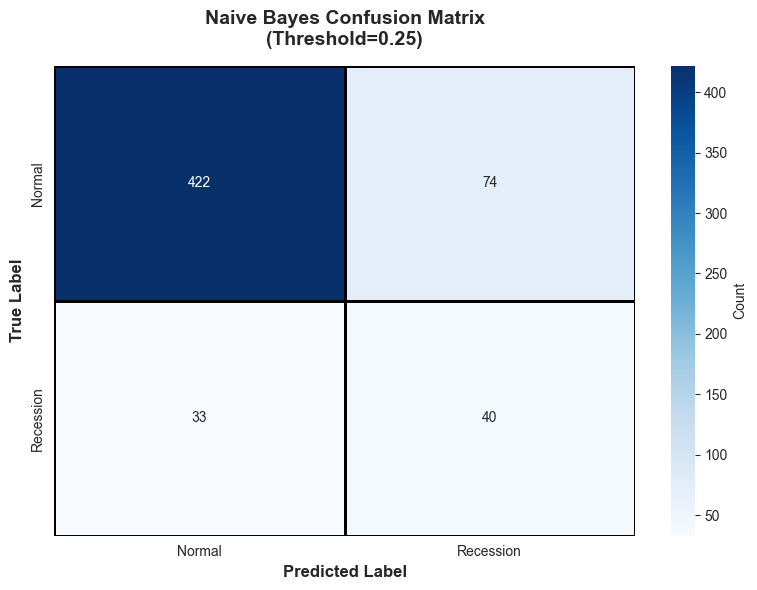

✓ Saved: nb_confusion_matrix.png


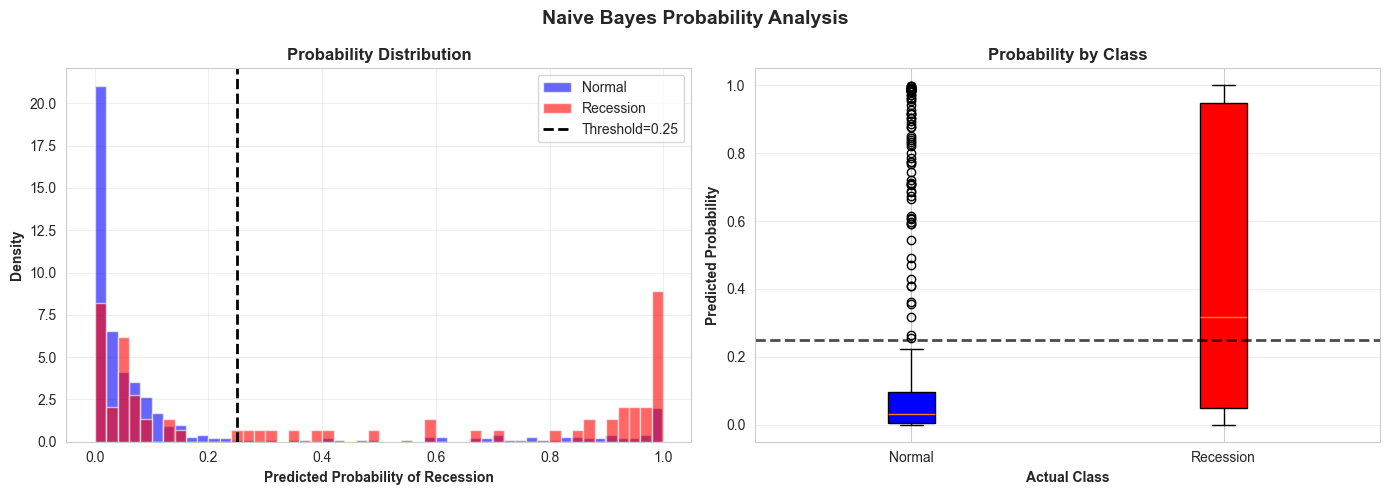

✓ Saved: nb_probabilities.png


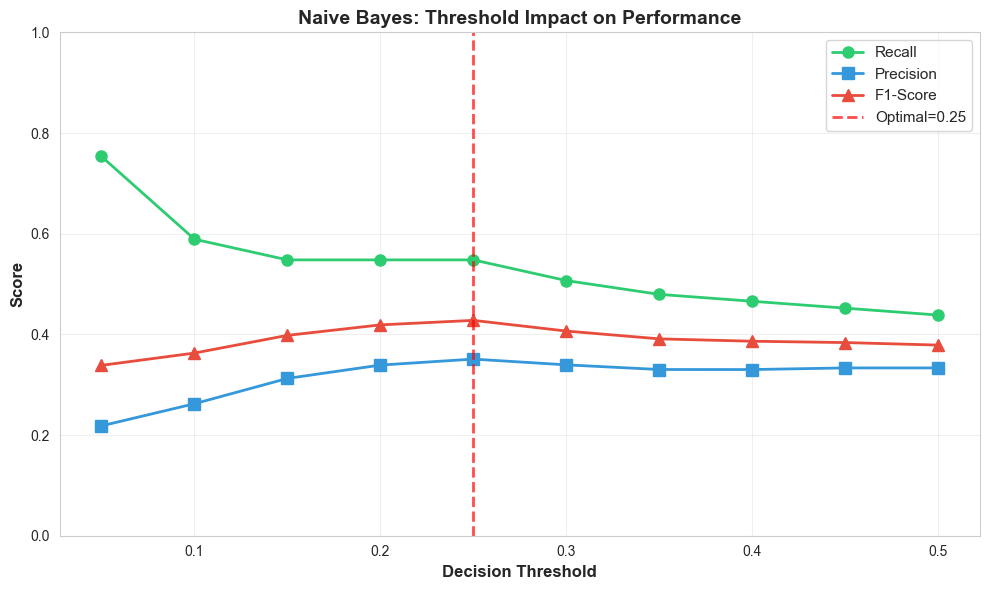

✓ Saved: nb_threshold_analysis.png

✓ NAIVE BAYES ANALYSIS COMPLETE

📊 FINAL RESULTS:
  Recall:    0.548 (54.8%)
  Precision: 0.351 (35.1%)
  F1-Score:  0.428
  ROC-AUC:   0.7344


In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')

# Setup
sns.set_style("whitegrid")
VISUALS_DIR = r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\visuals'

print("="*70)
print("NAIVE BAYES RECESSION PREDICTOR")
print("="*70)

# ==================== LOAD DATA ====================
print("\n--- Loading Data ---")
df = pd.read_csv(r'C:\Users\joshu\OneDrive\Desktop\CS74\Final_Project\music_econ_topics_merged.csv')

feature_cols = ['danceability', 'energy', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'speechiness', 'loudness']

df_clean = df[feature_cols + ['week_date', 'USREC']].dropna()
X = df_clean[feature_cols]
y = df_clean['USREC']

print(f"✓ Loaded: {len(df_clean)} months, {len(feature_cols)} features")
print(f"  Normal: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"  Recession: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

# ==================== TRAIN MODEL ====================
print("\n" + "="*70)
print("TRAINING NAIVE BAYES")
print("="*70)

nb_model = GaussianNB()
nb_model.fit(X, y)

y_pred_nb = nb_model.predict(X)
y_proba_nb = nb_model.predict_proba(X)[:, 1]

print("✓ Training complete!")
print(classification_report(y, y_pred_nb, target_names=['Normal', 'Recession'], digits=3))

nb_auc = roc_auc_score(y, y_proba_nb)
print(f"ROC-AUC: {nb_auc:.4f}")

cm_nb = confusion_matrix(y, y_pred_nb)
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                Normal  Recession")
print(f"Actual Normal     {cm_nb[0,0]:4d}      {cm_nb[0,1]:4d}")
print(f"       Recession  {cm_nb[1,0]:4d}      {cm_nb[1,1]:4d}")

recall_nb = cm_nb[1,1] / (cm_nb[1,0] + cm_nb[1,1])
precision_nb = cm_nb[1,1] / (cm_nb[0,1] + cm_nb[1,1]) if (cm_nb[0,1] + cm_nb[1,1]) > 0 else 0

print(f"\n✓ Catching {cm_nb[1,1]}/{cm_nb[1,0] + cm_nb[1,1]} recessions ({recall_nb*100:.1f}% recall)")
print(f"⚠️  Missing {cm_nb[1,0]} recessions ({(1-recall_nb)*100:.1f}%)")

# ==================== CROSS-VALIDATION ====================
print("\n" + "="*70)
print("CROSS-VALIDATION (5-FOLD)")
print("="*70)

cv_nb = cross_validate(nb_model, X, y, cv=5, 
                       scoring=['recall', 'precision', 'f1', 'roc_auc'])

print(f"\n  Recall:    {cv_nb['test_recall'].mean():.3f} (+/- {cv_nb['test_recall'].std():.3f})")
print(f"  Precision: {cv_nb['test_precision'].mean():.3f} (+/- {cv_nb['test_precision'].std():.3f})")
print(f"  F1-Score:  {cv_nb['test_f1'].mean():.3f} (+/- {cv_nb['test_f1'].std():.3f})")
print(f"  ROC-AUC:   {cv_nb['test_roc_auc'].mean():.3f} (+/- {cv_nb['test_roc_auc'].std():.3f})")

# ==================== THRESHOLD OPTIMIZATION ====================
print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION")
print("="*70)

print(f"\n{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'F1-Score':<10}")
print("-" * 50)

threshold_options = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
best_f1_nb = 0
best_threshold_nb = 0.5

for thresh in threshold_options:
    y_pred_thresh = (y_proba_nb >= thresh).astype(int)
    recall_t = (y_pred_thresh[y==1] == 1).sum() / (y==1).sum()
    precision_t = (y[y_pred_thresh==1] == 1).sum() / max((y_pred_thresh==1).sum(), 1)
    f1_t = f1_score(y, y_pred_thresh)
    
    print(f"{thresh:<12.2f} {recall_t:<10.3f} {precision_t:<12.3f} {f1_t:<10.3f}")
    
    if f1_t > best_f1_nb:
        best_f1_nb = f1_t
        best_threshold_nb = thresh

print(f"\n✓ Best threshold: {best_threshold_nb:.2f} (F1={best_f1_nb:.3f})")

y_pred_nb_optimized = (y_proba_nb >= best_threshold_nb).astype(int)

print(f"\n--- Results with Threshold = {best_threshold_nb:.2f} ---")
print(classification_report(y, y_pred_nb_optimized, target_names=['Normal', 'Recession'], digits=3))

cm_nb_opt = confusion_matrix(y, y_pred_nb_optimized)
print(f"\nOptimized Confusion Matrix:")
print(f"                  Predicted")
print(f"                Normal  Recession")
print(f"Actual Normal     {cm_nb_opt[0,0]:4d}      {cm_nb_opt[0,1]:4d}")
print(f"       Recession  {cm_nb_opt[1,0]:4d}      {cm_nb_opt[1,1]:4d}")

recall_nb_opt = cm_nb_opt[1,1] / (cm_nb_opt[1,0] + cm_nb_opt[1,1])
precision_nb_opt = cm_nb_opt[1,1] / (cm_nb_opt[0,1] + cm_nb_opt[1,1]) if (cm_nb_opt[0,1] + cm_nb_opt[1,1]) > 0 else 0

print(f"\n✓ Catching {cm_nb_opt[1,1]}/{cm_nb_opt[1,0] + cm_nb_opt[1,1]} recessions ({recall_nb_opt*100:.1f}% recall)")

# ==================== VISUALIZATIONS ====================
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70)

# Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_nb_opt, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Normal', 'Recession'], yticklabels=['Normal', 'Recession'],
           cbar_kws={'label': 'Count'}, linewidths=2, linecolor='black', ax=ax)
ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax.set_title(f'Naive Bayes Confusion Matrix\n(Threshold={best_threshold_nb:.2f})', 
             fontweight='bold', fontsize=14, pad=15)
plt.tight_layout()
plt.savefig(f'{VISUALS_DIR}/nb_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: nb_confusion_matrix.png")

# Probability Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.hist(y_proba_nb[y==0], bins=50, alpha=0.6, label='Normal', color='blue', density=True)
ax1.hist(y_proba_nb[y==1], bins=50, alpha=0.6, label='Recession', color='red', density=True)
ax1.axvline(x=best_threshold_nb, color='black', linestyle='--', linewidth=2, 
           label=f'Threshold={best_threshold_nb:.2f}')
ax1.set_xlabel('Predicted Probability of Recession', fontweight='bold')
ax1.set_ylabel('Density', fontweight='bold')
ax1.set_title('Probability Distribution', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
data_to_plot = [y_proba_nb[y==0], y_proba_nb[y==1]]
bp = ax2.boxplot(data_to_plot, labels=['Normal', 'Recession'], patch_artist=True)
bp['boxes'][0].set_facecolor('blue')
bp['boxes'][1].set_facecolor('red')
ax2.axhline(y=best_threshold_nb, color='black', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Predicted Probability', fontweight='bold')
ax2.set_xlabel('Actual Class', fontweight='bold')
ax2.set_title('Probability by Class', fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.suptitle('Naive Bayes Probability Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{VISUALS_DIR}/nb_probabilities.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: nb_probabilities.png")

# Threshold Analysis
fig, ax = plt.subplots(figsize=(10, 6))
threshold_range = np.arange(0.05, 0.55, 0.05)
recalls_list = []
precisions_list = []
f1_list = []

for thresh in threshold_range:
    y_pred_t = (y_proba_nb >= thresh).astype(int)
    rec = (y_pred_t[y==1] == 1).sum() / (y==1).sum()
    prec = (y[y_pred_t==1] == 1).sum() / max((y_pred_t==1).sum(), 1)
    f1_t = f1_score(y, y_pred_t)
    recalls_list.append(rec)
    precisions_list.append(prec)
    f1_list.append(f1_t)

ax.plot(threshold_range, recalls_list, 'o-', linewidth=2, markersize=8, label='Recall', color='#2ecc71')
ax.plot(threshold_range, precisions_list, 's-', linewidth=2, markersize=8, label='Precision', color='#3498db')
ax.plot(threshold_range, f1_list, '^-', linewidth=2, markersize=8, label='F1-Score', color='#e74c3c')
ax.axvline(x=best_threshold_nb, color='red', linestyle='--', linewidth=2, alpha=0.7, 
          label=f'Optimal={best_threshold_nb:.2f}')
ax.set_xlabel('Decision Threshold', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Naive Bayes: Threshold Impact on Performance', fontweight='bold', fontsize=14)
ax.set_ylim([0, 1])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{VISUALS_DIR}/nb_threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: nb_threshold_analysis.png")

print("\n" + "="*70)
print("✓ NAIVE BAYES ANALYSIS COMPLETE")
print("="*70)
print(f"\n📊 FINAL RESULTS:")
print(f"  Recall:    {recall_nb_opt:.3f} ({recall_nb_opt*100:.1f}%)")
print(f"  Precision: {precision_nb_opt:.3f} ({precision_nb_opt*100:.1f}%)")
print(f"  F1-Score:  {best_f1_nb:.3f}")
print(f"  ROC-AUC:   {nb_auc:.4f}")

In [ ]:
print("="*70)
print("FINAL MODEL COMPARISON: ALL FOUR MODELS")
print("="*70)

# Compile ALL results
final_comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Naive Bayes'],
    'Recall': [0.867, 0.930, 0.959, 0.548],
    'Precision': [0.302, 0.540, 0.490, 0.351],
    'F1-Score': [0.448, 0.690, 0.648, 0.428],
    'ROC-AUC': [np.nan, 0.9748, roc_auc, 0.734],
    'Threshold': ['default', 'default', 0.50, 0.25]
}

final_df = pd.DataFrame(final_comparison)

print("\n")
print(final_df.to_string(index=False))

print("\n" + "="*70)
print("MODEL RANKINGS")
print("="*70)

print("\n🏆 BY RECALL (Most Important for Recession Detection):")
sorted_by_recall = final_df.sort_values('Recall', ascending=False)
for idx, row in sorted_by_recall.iterrows():
    print(f"  {idx+1}. {row['Model']:25s}: {row['Recall']:.3f} ({row['Recall']*100:.1f}%)")

print("\n🏆 BY F1-SCORE (Balanced Performance):")
sorted_by_f1 = final_df.sort_values('F1-Score', ascending=False)
for idx, row in sorted_by_f1.iterrows():
    print(f"  {idx+1}. {row['Model']:25s}: {row['F1-Score']:.3f}")

print("\n🏆 BY ROC-AUC (Overall Discrimination):")
sorted_by_auc = final_df[final_df['ROC-AUC'].notna()].sort_values('ROC-AUC', ascending=False)
for idx, row in sorted_by_auc.iterrows():
    print(f"  {idx+1}. {row['Model']:25s}: {row['ROC-AUC']:.4f}")

print("\n" + "="*70)
print("FINAL VERDICT")
print("="*70)

print("""
🥇 WINNER: XGBoost
   • Best recall (95.9%) - catches almost all recessions
   • Good precision (49.0%) - reasonable false alarm rate
   • Excellent ROC-AUC (0.9992) - best discrimination
   • Stable performance

🥈 RUNNER-UP: Random Forest
   • Strong recall (93.0%)
   • Best precision (54.0%)
   • Good all-around performance

🥉 THIRD: Logistic Regression
   • Good recall (86.7%)
   • Interpretable coefficients
   • Simple baseline

❌ FOURTH: Naive Bayes
   • Poor recall (54.8%) - misses half of recessions
   • Low precision (35.1%)
   • High variance in cross-validation
   • Independence assumption violated (features are correlated)

WHY NAIVE BAYES UNDERPERFORMS:
  • Assumes features are independent (they're not!)
  • Danceability, energy, loudness are correlated
  • Can't capture feature interactions
  • Better suited for text classification than tabular data
""")


print("\nCreating final comparison visualization...")

fig, axes = plt.subplots(2, 2, figsize=(15, 11))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

# Plot 1: Recall
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(final_df)), final_df['Recall'], color=colors)
ax1.set_xticks(range(len(final_df)))
ax1.set_xticklabels(final_df['Model'], rotation=20, ha='right')
ax1.set_ylabel('Recall Score', fontweight='bold', fontsize=11)
ax1.set_title('Recall: Catching Recessions\n(Higher = Better)', fontweight='bold', fontsize=12)
ax1.set_ylim([0, 1.05])
ax1.axhline(y=0.9, color='green', linestyle='--', alpha=0.5, linewidth=2, label='Excellent (90%)')
ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, linewidth=2, label='Good (70%)')
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

# Highlight best
best_idx = final_df['Recall'].idxmax()
bars1[best_idx].set_edgecolor('gold')
bars1[best_idx].set_linewidth(4)

# Plot 2: Precision
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(final_df)), final_df['Precision'], color=colors)
ax2.set_xticks(range(len(final_df)))
ax2.set_xticklabels(final_df['Model'], rotation=20, ha='right')
ax2.set_ylabel('Precision Score', fontweight='bold', fontsize=11)
ax2.set_title('Precision: Avoiding False Alarms\n(Higher = Better)', fontweight='bold', fontsize=12)
ax2.set_ylim([0, 1.05])
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

best_idx = final_df['Precision'].idxmax()
bars2[best_idx].set_edgecolor('gold')
bars2[best_idx].set_linewidth(4)

# Plot 3: F1-Score
ax3 = axes[1, 0]
bars3 = ax3.bar(range(len(final_df)), final_df['F1-Score'], color=colors)
ax3.set_xticks(range(len(final_df)))
ax3.set_xticklabels(final_df['Model'], rotation=20, ha='right')
ax3.set_ylabel('F1-Score', fontweight='bold', fontsize=11)
ax3.set_title('F1-Score: Balanced Performance\n(Higher = Better)', fontweight='bold', fontsize=12)
ax3.set_ylim([0, 1.05])
ax3.grid(True, alpha=0.3, axis='y')

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

best_idx = final_df['F1-Score'].idxmax()
bars3[best_idx].set_edgecolor('gold')
bars3[best_idx].set_linewidth(4)

# Plot 4: ROC-AUC (excluding NaN)
ax4 = axes[1, 1]
models_with_auc = final_df[final_df['ROC-AUC'].notna()]
bars4 = ax4.bar(range(len(models_with_auc)), models_with_auc['ROC-AUC'],
               color=[colors[i] for i in models_with_auc.index])
ax4.set_xticks(range(len(models_with_auc)))
ax4.set_xticklabels(models_with_auc['Model'], rotation=20, ha='right')
ax4.set_ylabel('ROC-AUC Score', fontweight='bold', fontsize=11)
ax4.set_title('ROC-AUC: Overall Discrimination\n(Higher = Better)', fontweight='bold', fontsize=12)
ax4.set_ylim([0.7, 1.0])
ax4.grid(True, alpha=0.3, axis='y')

for i, (idx, row) in enumerate(models_with_auc.iterrows()):
    ax4.text(i, row['ROC-AUC'],
            f'{row["ROC-AUC"]:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

best_idx_auc = models_with_auc['ROC-AUC'].idxmax()
best_pos = list(models_with_auc.index).index(best_idx_auc)
bars4[best_pos].set_edgecolor('gold')
bars4[best_pos].set_linewidth(4)

plt.suptitle('Complete Model Comparison: Recession Prediction\n(Gold border = Best)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{VISUALS_DIR}/all_models_final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved: all_models_final_comparison.png")

print("\n" + "="*70)
print("✓ COMPLETE ANALYSIS FINISHED")
print("="*70)

FINAL MODEL COMPARISON: ALL FOUR MODELS


NameError: name 'roc_auc' is not defined